# Checking if a pair of stocks is cointegrated

## Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

In [2]:
# Set plotting options
%matplotlib inline
plt.rc('figure', figsize=(16, 9))

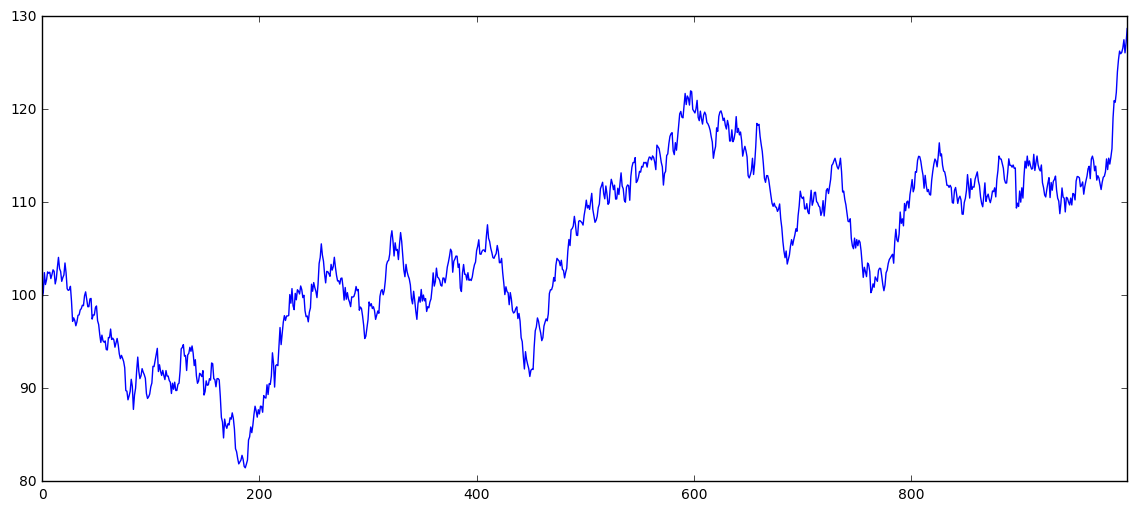

0       99.723232
1      100.305083
2      102.453483
3      101.173996
4      101.676273
5      102.532302
6      102.389512
7      102.499590
8      101.811526
9      102.245090
10     102.755311
11     102.590180
12     101.238401
13     101.785031
14     103.015687
15     104.092133
16     102.881508
17     102.574831
18     101.517412
19     101.919469
20     102.208634
21     103.491368
22     102.425672
23     100.719039
24     100.546242
25     100.609952
26     100.980580
27      99.376037
28      97.210308
29      97.590678
          ...    
970    113.905193
971    112.399905
972    112.872299
973    112.620617
974    112.025439
975    111.387173
976    112.167112
977    112.709639
978    112.822101
979    113.298540
980    114.678758
981    113.535515
982    114.761410
983    114.124274
984    114.878544
985    115.787657
986    119.114355
987    120.949131
988    120.777099
989    121.839639
990    124.046458
991    125.357239
992    126.277303
993    125.984843
994    126

In [3]:
# just set the seed for the random number generator
np.random.seed(2018)
# use returns to create a price series
drift = 100
r1 = np.random.normal(0, 1, 1000) 
s1 = pd.Series(np.cumsum(r1), name='s1') + drift
s1.plot(figsize=(14,6))
plt.show()
print(s1)

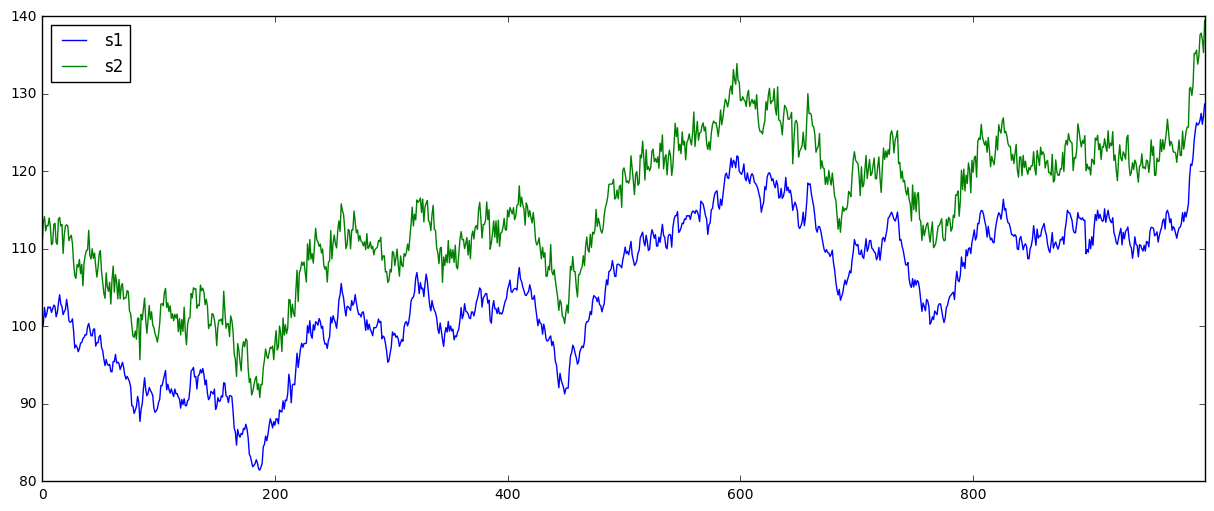

In [4]:
offset = 10
noise = np.random.randn(1000)
s2 = s1 + offset + noise # cointegration
s2.name = 's2'
pd.concat([s1, s2], axis = 1).plot(figsize = (15,6))
plt.show()

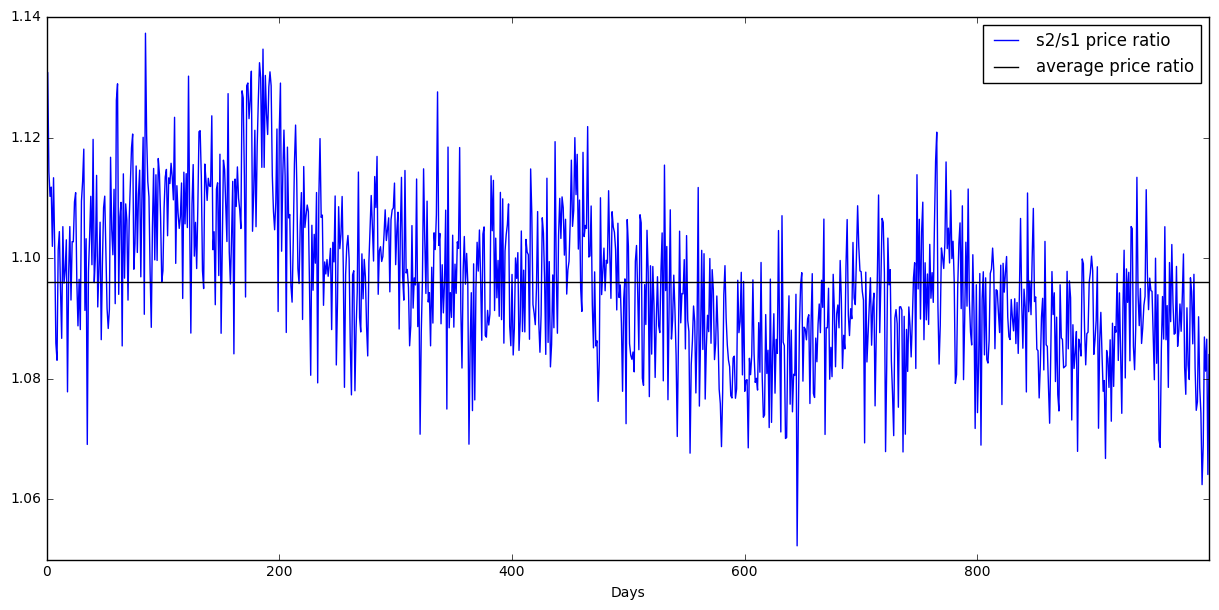

average price ratio: 1.0960


In [5]:
price_ratio = s2 / s1
price_ratio.plot(figsize = (15, 7))
plt.axhline(price_ratio.mean(), color = 'black')
plt.xlabel('Days')
plt.legend(['s2/s1 price ratio', 'average price ratio'])
plt.show()
print("average price ratio: %.4f" %price_ratio.mean())

## Calculate hedge ratio with regression

## Linear Regression

Note that the LinearRegression().fit() expects 2D numpy arrays.  Since s1 and s2 are pandas series, we can use Series.values to get the values as a numpy array. Since these are 1D arrays, we can use numpy.reshape(-1,1) to make these 1000 row by 1 column 2 dimensional arrays

In [6]:
type(s1)

pandas.core.series.Series

In [9]:
s1

0       99.723232
1      100.305083
2      102.453483
3      101.173996
4      101.676273
5      102.532302
6      102.389512
7      102.499590
8      101.811526
9      102.245090
10     102.755311
11     102.590180
12     101.238401
13     101.785031
14     103.015687
15     104.092133
16     102.881508
17     102.574831
18     101.517412
19     101.919469
20     102.208634
21     103.491368
22     102.425672
23     100.719039
24     100.546242
25     100.609952
26     100.980580
27      99.376037
28      97.210308
29      97.590678
          ...    
970    113.905193
971    112.399905
972    112.872299
973    112.620617
974    112.025439
975    111.387173
976    112.167112
977    112.709639
978    112.822101
979    113.298540
980    114.678758
981    113.535515
982    114.761410
983    114.124274
984    114.878544
985    115.787657
986    119.114355
987    120.949131
988    120.777099
989    121.839639
990    124.046458
991    125.357239
992    126.277303
993    125.984843
994    126

In [13]:
s1.reshape(-1,1).shape

(1000, 1)

In [17]:
lr = LinearRegression()
lr.fit(s1.reshape(-1, 1), s2.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
hedge_ratio = lr.coef_[0][0]
hedge_ratio

1.0022343577912765

In [26]:
intercept = lr.intercept_[0]
intercept

9.753022747192858

In [27]:
print('hedge ratio from regression is %.4f, intercept is %.4f' %(hedge_ratio, intercept))

hedge ratio from regression is 1.0022, intercept is 9.7530


 ## Question
 Do you think we'll need the intercept when calculating the spread?  Why or why not?
 
 ans. Yes we do. 

In [29]:
spread = s2 - s1 * hedge_ratio
spread.head()

0    10.619709
1    12.895335
2    11.483846
3    10.927591
4    11.138530
dtype: float64

In [31]:
print("Average spread is %.4f" %spread.mean())

Average spread is 9.7530


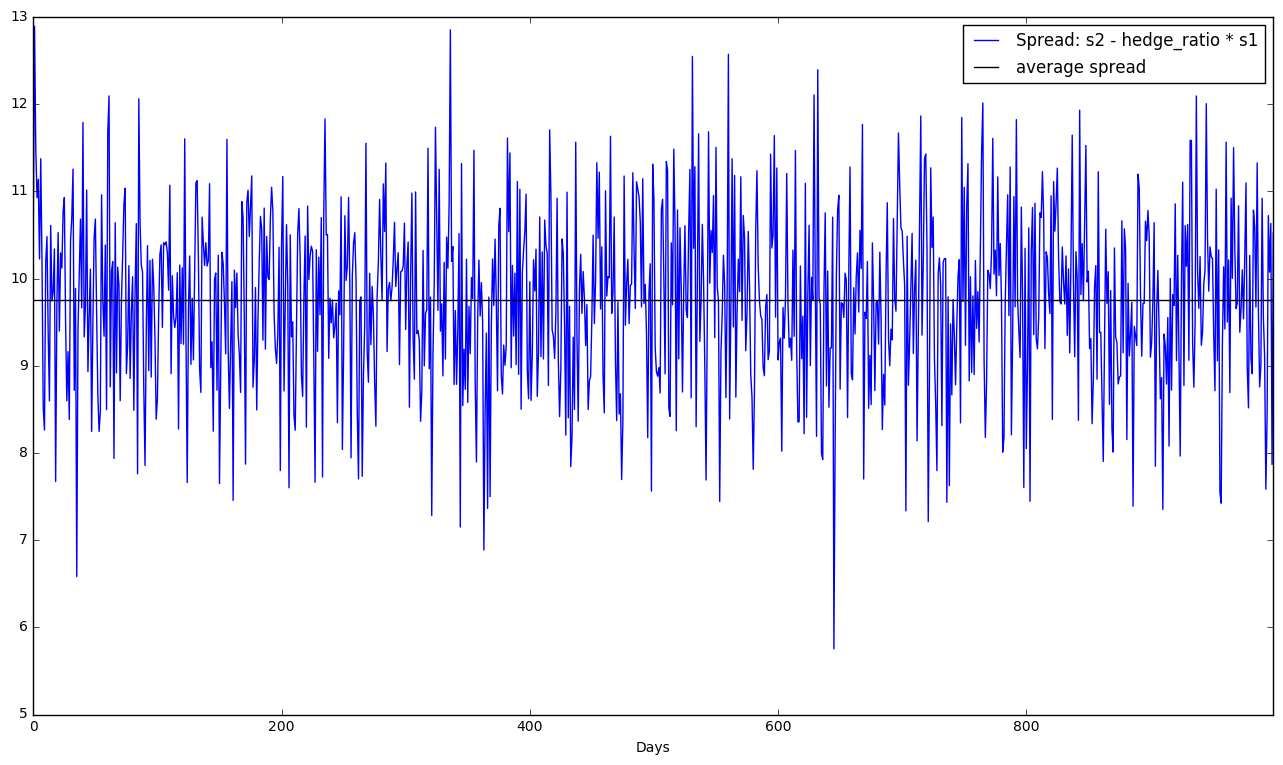

In [32]:
spread.plot()
plt.axhline(spread.mean(), color = 'black')
plt.xlabel('Days')
plt.legend(['Spread: s2 - hedge_ratio * s1', 'average spread'])
plt.show()

## Let's see what we get if we include the intercept of the regression

In [33]:
spread_with_intercept = s2 - (s1 * hedge_ratio + intercept)
print("Average spread with intercept included is %.4f" % spread_with_intercept.mean())

Average spread with intercept included is 0.0000


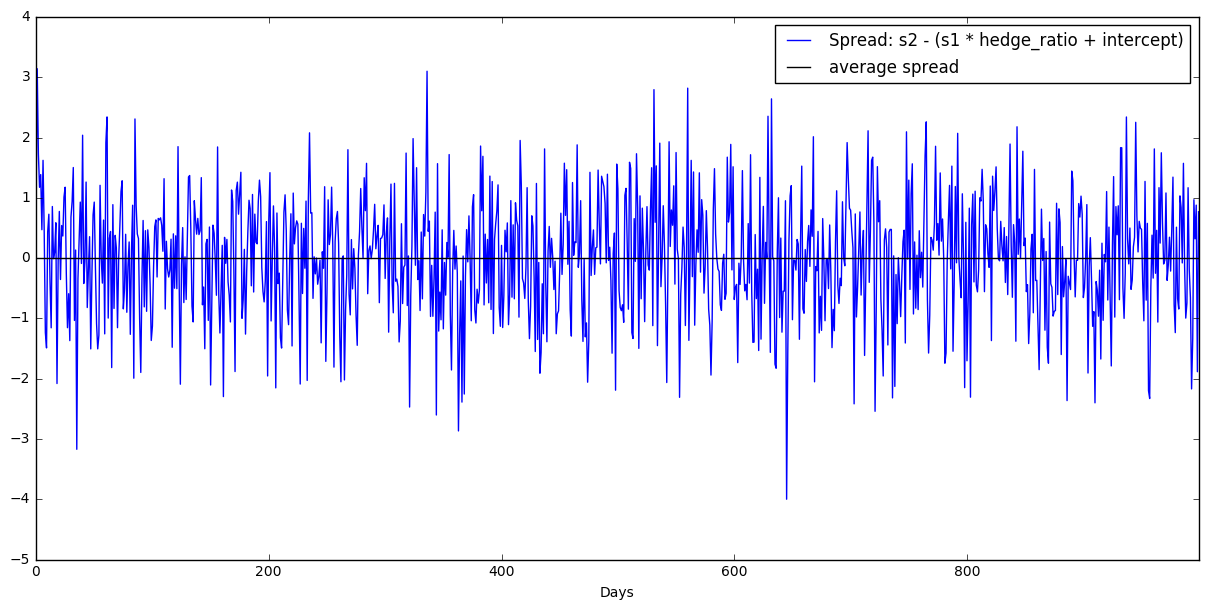

In [34]:
spread_with_intercept.plot(figsize = (15, 7))
plt.axhline(spread_with_intercept.mean(), color = 'black')
plt.xlabel('Days')
plt.legend(['Spread: s2 - (s1 * hedge_ratio + intercept)', 'average spread'])
plt.show()

## Quiz
### Check if spread is stationary using Augmented Dickey Fuller Test

The [adfuller](http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) function is part of the statsmodel library.

```
adfuller(x, maxlag=None, regression='c', autolag='AIC', store=False, regresults=False)[source]

adf (float) – Test statistic
pvalue (float) – p-value
...
```

In [41]:
adfuller(spread_with_intercept)[1]

0.0

In [52]:
def is_spread_stationary(spread, p_level=0.05):
    """
    spread: obtained from linear combination of two series with a hedge ratio
    
    p_level: level of significance required to reject null hypothesis of non-stationarity
    
    returns:
        True if spread can be considered stationary
        False otherwise
    """
    #TODO: use the adfuller function to check the spread
    adf_result = adfuller(spread)[0]
    
    #get the p-value
    pvalue = adfuller(spread)[1]
    
    print("p-value : %.4f" %pvalue)
    if pvalue <= p_level:
        print("p-value is <= %.2f, assume spread is stationary" % p_level)
        return True
    else:
        print("p-value is > %.2f, assume spread is not stationary" % p_level)
        return False

In [54]:
# Try out your function
print("Are the two series candidates for pairs trading? %s" %is_spread_stationary(spread))

p-value : 0.0000
p-value is <= 0.05, assume spread is stationary
Are the two series candidates for pairs trading? True
